## Attach Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Capsnet

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import csv
import math
import pandas

def plot_log(filename, show=True):

    data = pandas.read_csv(filename)

#     fig = plt.figure(figsize=(4,6))
#     fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
#     fig.add_subplot(211)
    for key in data.keys():
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training loss')
    plt.savefig('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/capsnet_date_loss.png')
    if show:
        plt.show()
    print ("Loss")
#     fig.add_subplot(212)
    for key in data.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training and validation accuracy')
    plt.savefig('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/capsnet_date_accuracy.png')
    
    # fig.savefig('result/log.png')
    if show:
        plt.show()


def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

# if __name__=="__main__":
# plot_log('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/result/log.csv')




In [0]:
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset, 
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.

Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import keras.backend as K
import tensorflow as tf
from keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""

'\n# The following is another way to implement primary capsule layer. This is much slower.\n# Apply Conv2D `n_channels` times and concatenate all capsules\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n    outputs = []\n    for _ in range(n_channels):\n        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)\n        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    outputs = layers.Concatenate(axis=1)(outputs)\n    return layers.Lambda(squash)(outputs)\n'

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_13[0][0]                   
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(896, 28, 28, 1)
(896, 28, 28, 1) 112
------------------------------Begin: Prediction------------------------------
[1 5 0 3 2 0 1 6] (8,)

------------------------------End: test------------------------------


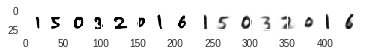

(8,)
['Cheque 083654', '1', '5', '0', '3', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 7 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


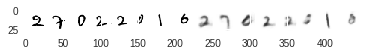

(8,)
['Cheque 083655', '2', '7', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 1 0 3 2 0 1 6] (8,)

------------------------------End: test------------------------------


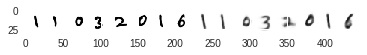

(8,)
['Cheque 083656', '1', '1', '0', '3', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 3 0 3 2 0 1 6] (8,)

------------------------------End: test------------------------------


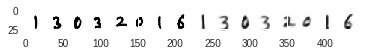

(8,)
['Cheque 083657', '1', '3', '0', '3', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[0 8 0 1 2 0 1 3] (8,)

------------------------------End: test------------------------------


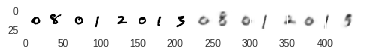

(8,)
['Cheque 083658', '0', '8', '0', '1', '2', '0', '1', '3']
------------------------------Begin: Prediction------------------------------
[1 3 0 7 2 2 1 2] (8,)

------------------------------End: test------------------------------


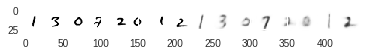

(8,)
['Cheque 083659', '1', '3', '0', '7', '2', '2', '1', '2']
------------------------------Begin: Prediction------------------------------
[1 2 0 5 2 0 1 5] (8,)

------------------------------End: test------------------------------


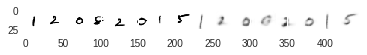

(8,)
['Cheque 083660', '1', '2', '0', '5', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


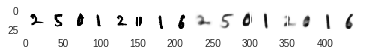

(8,)
['Cheque 100828', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[0 1 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


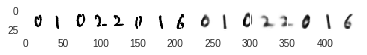

(8,)
['Cheque 100829', '0', '1', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[0 8 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


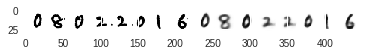

(8,)
['Cheque 100830', '0', '8', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 5 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


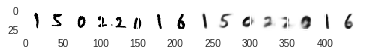

(8,)
['Cheque 100831', '1', '5', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 0 0 4 2 0 1 6] (8,)

------------------------------End: test------------------------------


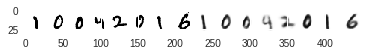

(8,)
['Cheque 100832', '1', '0', '0', '4', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 0 0 3 2 0 1 6] (8,)

------------------------------End: test------------------------------


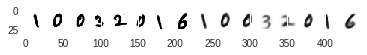

(8,)
['Cheque 100833', '1', '0', '0', '3', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 6 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


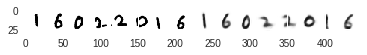

(8,)
['Cheque 100834', '1', '6', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 5 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


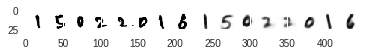

(8,)
['Cheque 100835', '1', '5', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 2 0 9 2 0 0 9] (8,)

------------------------------End: test------------------------------


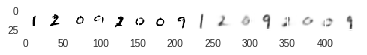

(8,)
['Cheque 120611', '1', '2', '0', '9', '2', '0', '0', '9']
------------------------------Begin: Prediction------------------------------
[0 6 0 6 2 0 0 9] (8,)

------------------------------End: test------------------------------


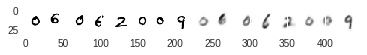

(8,)
['Cheque 120612', '0', '6', '0', '6', '2', '0', '0', '9']
------------------------------Begin: Prediction------------------------------
[0 1 1 0 2 0 0 5] (8,)

------------------------------End: test------------------------------


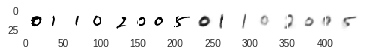

(8,)
['Cheque 120613', '0', '1', '1', '0', '2', '0', '0', '5']
------------------------------Begin: Prediction------------------------------
[2 3 1 2 2 0 0 6] (8,)

------------------------------End: test------------------------------


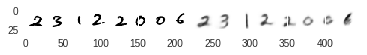

(8,)
['Cheque 120614', '2', '3', '1', '2', '2', '0', '0', '6']
------------------------------Begin: Prediction------------------------------
[1 2 1 2 2 0 1 2] (8,)

------------------------------End: test------------------------------


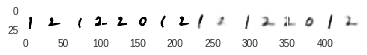

(8,)
['Cheque 120615', '1', '2', '1', '2', '2', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[1 1 1 2 2 0 1 4] (8,)

------------------------------End: test------------------------------


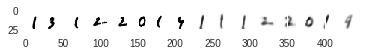

(8,)
['Cheque 120616', '1', '1', '1', '2', '2', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[2 4 0 8 2 0 1 3] (8,)

------------------------------End: test------------------------------


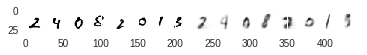

(8,)
['Cheque 120617', '2', '4', '0', '8', '2', '0', '1', '3']
------------------------------Begin: Prediction------------------------------
[2 2 0 9 2 0 1 9] (8,)

------------------------------End: test------------------------------


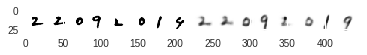

(8,)
['Cheque 120618', '2', '2', '0', '9', '2', '0', '1', '9']
------------------------------Begin: Prediction------------------------------
[1 3 1 2 2 2 1 1] (8,)

------------------------------End: test------------------------------


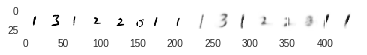

(8,)
['Cheque 120619', '1', '3', '1', '2', '2', '2', '1', '1']
------------------------------Begin: Prediction------------------------------
[2 2 1 2 2 2 2 5] (8,)

------------------------------End: test------------------------------


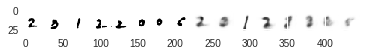

(8,)
['Cheque 120620', '2', '2', '1', '2', '2', '2', '2', '5']
------------------------------Begin: Prediction------------------------------
[1 5 0 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


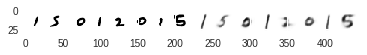

(8,)
['Cheque 309061', '1', '5', '0', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


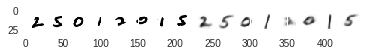

(8,)
['Cheque 309062', '2', '5', '0', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 9 6 1 2 2 1 6] (8,)

------------------------------End: test------------------------------


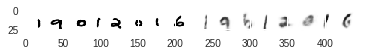

(8,)
['Cheque 309063', '1', '9', '6', '1', '2', '2', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 4 0 1 2 2 1 4] (8,)

------------------------------End: test------------------------------


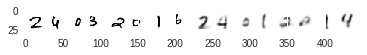

(8,)
['Cheque 309066', '2', '4', '0', '1', '2', '2', '1', '4']
------------------------------Begin: Prediction------------------------------
[2 5 2 3 2 0 1 6] (8,)

------------------------------End: test------------------------------


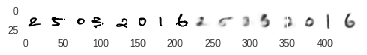

(8,)
['Cheque 309067', '2', '5', '2', '3', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[3 0 0 4 2 0 1 6] (8,)

------------------------------End: test------------------------------


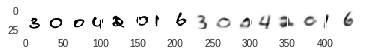

(8,)
['Cheque 309068', '3', '0', '0', '4', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[8 2 6 5 2 0 1 6] (8,)

------------------------------End: test------------------------------


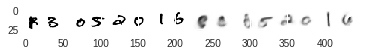

(8,)
['Cheque 309069', '8', '2', '6', '5', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 9 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


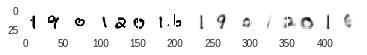

(8,)
['Cheque 309070', '1', '9', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


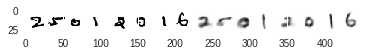

(8,)
['Cheque 309071', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 0 2 1 2 0 1 0] (8,)

------------------------------End: test------------------------------


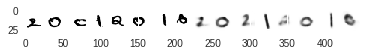

(8,)
['Cheque 309072', '2', '0', '2', '1', '2', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 5 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


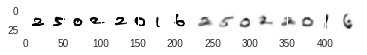

(8,)
['Cheque 309073', '2', '5', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[3 2 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


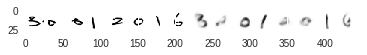

(8,)
['Cheque 309074', '3', '2', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[8 0 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


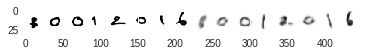

(8,)
['Cheque 309075', '8', '0', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


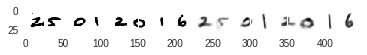

(8,)
['Cheque 309076', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 9 2 7 2 0 1 4] (8,)

------------------------------End: test------------------------------


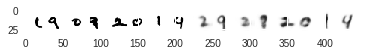

(8,)
['Cheque 309077', '2', '9', '2', '7', '2', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[1 4 0 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


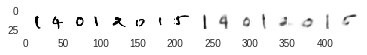

(8,)
['Cheque 309078', '1', '4', '0', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 5 2 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


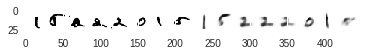

(8,)
['Cheque 309079', '1', '5', '2', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 0 0 5 2 0 1 0] (8,)

------------------------------End: test------------------------------


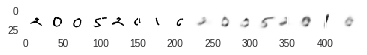

(8,)
['Cheque 309080', '2', '0', '0', '5', '2', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 2 0 4 2 2 1 5] (8,)

------------------------------End: test------------------------------


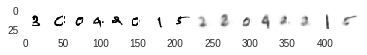

(8,)
['Cheque 309082', '2', '2', '0', '4', '2', '2', '1', '5']
------------------------------Begin: Prediction------------------------------
[7 3 0 3 2 0 1 3] (8,)

------------------------------End: test------------------------------


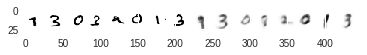

(8,)
['Cheque 309083', '7', '3', '0', '3', '2', '0', '1', '3']
------------------------------Begin: Prediction------------------------------
[1 2 2 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


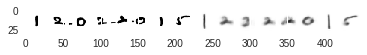

(8,)
['Cheque 309084', '1', '2', '2', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 2 0 2 2 0 0 2] (8,)

------------------------------End: test------------------------------


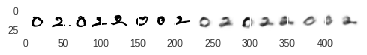

(8,)
['Cheque 309086', '0', '2', '0', '2', '2', '0', '0', '2']
------------------------------Begin: Prediction------------------------------
[1 1 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


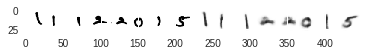

(8,)
['Cheque 309089', '1', '1', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 7 0 2 2 0 2 7] (8,)

------------------------------End: test------------------------------


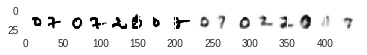

(8,)
['Cheque 309090', '0', '7', '0', '2', '2', '0', '2', '7']
------------------------------Begin: Prediction------------------------------
[1 0 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


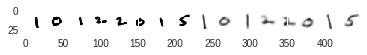

(8,)
['Cheque 309091', '1', '0', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 3 0 1 2 0 1 8] (8,)

------------------------------End: test------------------------------


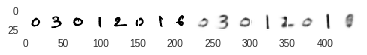

(8,)
['Cheque 309092', '0', '3', '0', '1', '2', '0', '1', '8']
------------------------------Begin: Prediction------------------------------
[1 3 0 1 2 0 1 4] (8,)

------------------------------End: test------------------------------


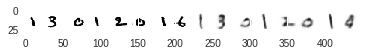

(8,)
['Cheque 309093', '1', '3', '0', '1', '2', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[1 1 1 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


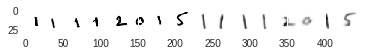

(8,)
['Cheque 309094', '1', '1', '1', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[3 0 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


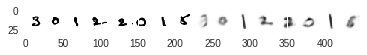

(8,)
['Cheque 309095', '3', '0', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 9 0 9 2 0 1 5] (8,)

------------------------------End: test------------------------------


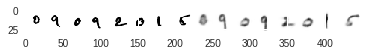

(8,)
['Cheque 309096', '0', '9', '0', '9', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 0 1 0 2 2 1 5] (8,)

------------------------------End: test------------------------------


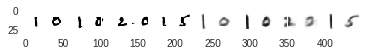

(8,)
['Cheque 309097', '1', '0', '1', '0', '2', '2', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 0 0 7 2 0 1 5] (8,)

------------------------------End: test------------------------------


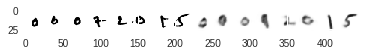

(8,)
['Cheque 309098', '0', '0', '0', '7', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 9 1 1 2 2 1 5] (8,)

------------------------------End: test------------------------------


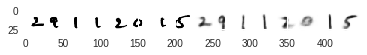

(8,)
['Cheque 309099', '2', '9', '1', '1', '2', '2', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 9 1 1 2 2 1 5] (8,)

------------------------------End: test------------------------------


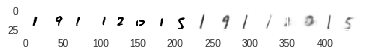

(8,)
['Cheque 309100', '1', '9', '1', '1', '2', '2', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 7 0 7 2 0 1 5] (8,)

------------------------------End: test------------------------------


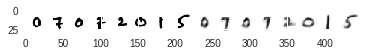

(8,)
['Cheque 309101', '0', '7', '0', '7', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 4 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


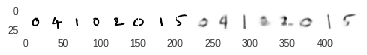

(8,)
['Cheque 309102', '0', '4', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 0 0 7 2 0 1 5] (8,)

------------------------------End: test------------------------------


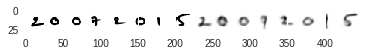

(8,)
['Cheque 309103', '2', '0', '0', '7', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 0 0 9 2 0 1 5] (8,)

------------------------------End: test------------------------------


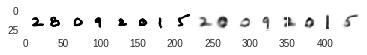

(8,)
['Cheque 309104', '2', '0', '0', '9', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 8 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


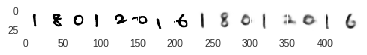

(8,)
['Cheque 309105', '1', '8', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 9 0 1 2 7 1 6] (8,)

------------------------------End: test------------------------------


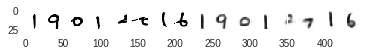

(8,)
['Cheque 309106', '1', '9', '0', '1', '2', '7', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 9 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


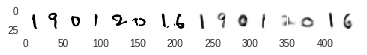

(8,)
['Cheque 309107', '1', '9', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 9 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


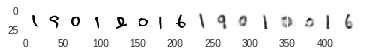

(8,)
['Cheque 309108', '1', '9', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 0 6 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


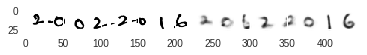

(8,)
['Cheque 309109', '2', '0', '6', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 0 0 2 2 0 1 2] (8,)

------------------------------End: test------------------------------


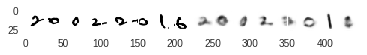

(8,)
['Cheque 309110', '2', '0', '0', '2', '2', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[2 2 2 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


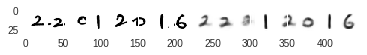

(8,)
['Cheque 309111', '2', '2', '2', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 1 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


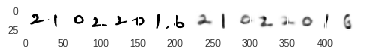

(8,)
['Cheque 309112', '2', '1', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 1 0 2 2 0 1 6] (8,)

------------------------------End: test------------------------------


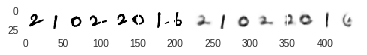

(8,)
['Cheque 309113', '2', '1', '0', '2', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 2 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


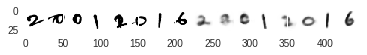

(8,)
['Cheque 309114', '2', '2', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 1 0 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


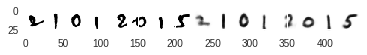

(8,)
['Cheque 309115', '2', '1', '0', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 1 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


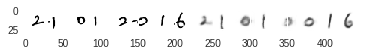

(8,)
['Cheque 309116', '2', '1', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[3 0 0 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


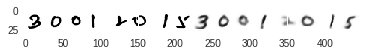

(8,)
['Cheque 309117', '3', '0', '0', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 0 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


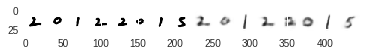

(8,)
['Cheque 309118', '2', '0', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 9 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


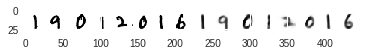

(8,)
['Cheque 309119', '1', '9', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 0 0 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


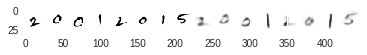

(8,)
['Cheque 309121', '2', '0', '0', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 2 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


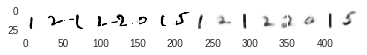

(8,)
['Cheque 309122', '1', '2', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 5 1 2 2 3 1 5] (8,)

------------------------------End: test------------------------------


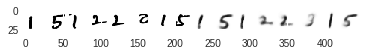

(8,)
['Cheque 309123', '1', '5', '1', '2', '2', '3', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 6 1 2 2 9 1 5] (8,)

------------------------------End: test------------------------------


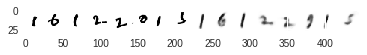

(8,)
['Cheque 309124', '1', '6', '1', '2', '2', '9', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 7 1 2 2 2 1 5] (8,)

------------------------------End: test------------------------------


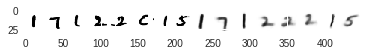

(8,)
['Cheque 309125', '1', '7', '1', '2', '2', '2', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 8 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


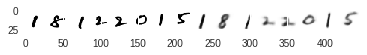

(8,)
['Cheque 309126', '1', '8', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 9 1 2 2 2 1 5] (8,)

------------------------------End: test------------------------------


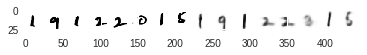

(8,)
['Cheque 309127', '1', '9', '1', '2', '2', '2', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 9 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


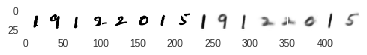

(8,)
['Cheque 309128', '1', '9', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 0 1 2 2 2 1 5] (8,)

------------------------------End: test------------------------------


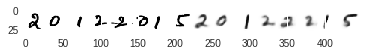

(8,)
['Cheque 309129', '2', '0', '1', '2', '2', '2', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 0 1 2 2 1 4 5] (8,)

------------------------------End: test------------------------------


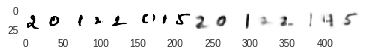

(8,)
['Cheque 309130', '2', '0', '1', '2', '2', '1', '4', '5']
------------------------------Begin: Prediction------------------------------
[1 2 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


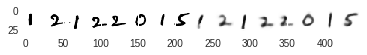

(8,)
['Cheque 309131', '1', '2', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 0 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


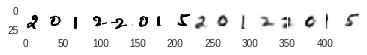

(8,)
['Cheque 309133', '2', '0', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 3 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


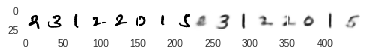

(8,)
['Cheque 309134', '2', '3', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


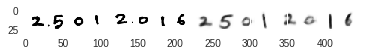

(8,)
['Cheque 309135', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


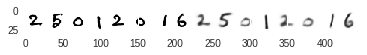

(8,)
['Cheque 309136', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


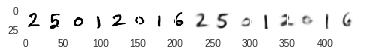

(8,)
['Cheque 309137', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


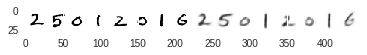

(8,)
['Cheque 309138', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


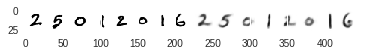

(8,)
['Cheque 309139', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


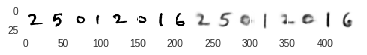

(8,)
['Cheque 309141', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 0 6] (8,)

------------------------------End: test------------------------------


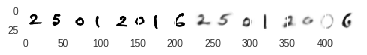

(8,)
['Cheque 309142', '2', '5', '0', '1', '2', '0', '0', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


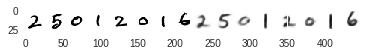

(8,)
['Cheque 309144', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


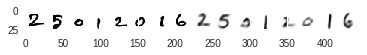

(8,)
['Cheque 309145', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


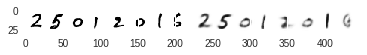

(8,)
['Cheque 309147', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


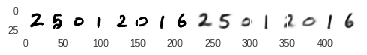

(8,)
['Cheque 309148', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[1 9 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


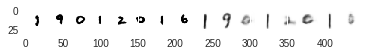

(8,)
['Cheque 309149', '1', '9', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 0 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


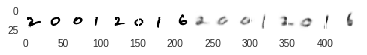

(8,)
['Cheque 309150', '2', '0', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 1 2 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


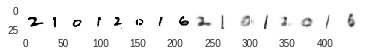

(8,)
['Cheque 309151', '2', '1', '2', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 3 0 1 2 0 1 6] (8,)

------------------------------End: test------------------------------


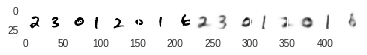

(8,)
['Cheque 309153', '2', '3', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 0 2 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


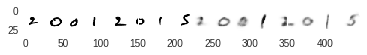

(8,)
['Cheque 309155', '2', '0', '2', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[2 7 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


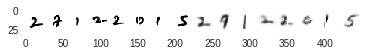

(8,)
['Cheque 309156', '2', '7', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 7 2 5 2 0 1 4] (8,)

------------------------------End: test------------------------------


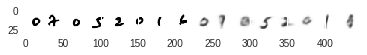

(8,)
['Cheque 309157', '0', '7', '2', '5', '2', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[2 0 1 2 2 0 1 5] (8,)

------------------------------End: test------------------------------


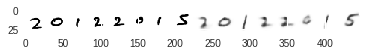

(8,)
['Cheque 309158', '2', '0', '1', '2', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[1 9 1 1 2 0 1 5] (8,)

------------------------------End: test------------------------------


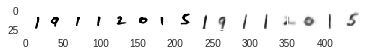

(8,)
['Cheque 309159', '1', '9', '1', '1', '2', '0', '1', '5']
------------------------------Begin: Prediction------------------------------
[0 5 2 3 2 0 1 6] (8,)

------------------------------End: test------------------------------


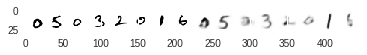

(8,)
['Cheque 309160', '0', '5', '2', '3', '2', '0', '1', '6']


In [0]:
"""
Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
Adopting to other backends should be easy, but I have not tested this. 
Usage:
       python capsulenet.py
       python capsulenet.py --epochs 50
       python capsulenet.py --epochs 50 --routings 3
       ... ...
       
Result:
    Validation accuracy > 99.5% after 20 epochs. Converge to 99.66% after 50 epochs.
    About 110 seconds per epoch on a single GTX1070 GPU card
    
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import cv2

K.set_image_data_format('channels_last')


# def CapsNet(input_shape, n_class, routings):
#     """
#     A Capsule Network on MNIST.
#     :param input_shape: data shape, 3d, [width, height, channels]
#     :param n_class: number of classes
#     :param routings: number of routing iterations
#     :return: Two Keras Models, the first one used for training, and the second one for evaluation.
#             `eval_model` can also be used for training.
#     """
#     x = layers.Input(shape=input_shape)

#     # Layer 1: Just a conventional Conv2D layer
#     conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

#     # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
#     primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

#     # Layer 3: Capsule layer. Routing algorithm works here.
#     digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
#                              name='digitcaps')(primarycaps)

#     # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
#     # If using tensorflow, this will not be necessary. :)
#     out_caps = Length(name='capsnet')(digitcaps)

#     # Decoder network.
#     y = layers.Input(shape=(n_class,))
#     masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
#     masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

#     # Shared Decoder model in training and prediction
#     decoder = models.Sequential(name='decoder')
#     decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
#     decoder.add(layers.Dense(1024, activation='relu'))
#     decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
#     decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

#     # Models for training and evaluation (prediction)
#     train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
#     eval_model = models.Model(x, [out_caps, decoder(masked)])

#     # manipulate model
#     noise = layers.Input(shape=(n_class, 16))
#     noised_digitcaps = layers.Add()([digitcaps, noise])
#     masked_noised_y = Mask()([noised_digitcaps, y])
#     manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
#     return train_model, eval_model, manipulate_model

def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model
  
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv', append = True)
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

#     from utils import plot_log
    plot_log(args.save_dir + '/log.csv', show=True)

    return model


def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()
    
def test_my_data(model, data, args):
    x_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=8)
    print('-'*30 + 'Begin: Prediction' + '-'*30)
#     print('-'*30 + y_pred + '-'*30)
#     print(y_pred)
    output = np.argmax(y_pred, axis=1)
    print (output, output.shape)
    
    img = combine_images(np.concatenate([x_test[:],x_recon[:]]), height = 1)
#     img = combine_images(x_test, height = 1)
    image = img * 255
    image = image.astype(np.uint8)
#     cv2.imwrite("/detected-boxes.jpg", image)
    #Image.fromarray(image).save(args.save_dir + "/real_and_recon.png")
    print()
#     print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
#     plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
#     plt.imshow(plt.imread("/detected-boxes.jpg"))
    plt.imshow(image)
    plt.show()
    return output
    
# def test_my_data(model, data, args):
#     x_test = data
#     y_pred, x_recon = model.predict(x_test, batch_size=1)
#     print('-'*30 + 'Begin: Prediction' + '-'*30)
# #     print('-'*30 + y_pred + '-'*30)
# #     print(y_pred)
#     print (np.argmax(y_pred, axis=1))

# #     img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
#     image = x_test[0] * 255
#     image = image.astype(np.uint8)
#     cv2.imwrite("/detected-boxes.jpg", image)
#     #Image.fromarray(image).save(args.save_dir + "/real_and_recon.png")
#     print()
# #     print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
#     print('-' * 30 + 'End: test' + '-' * 30)
# #     plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
#     plt.imshow(plt.imread("/detected-boxes.jpg"))
#     plt.show()
    
# def manipulate_latent(model, data, args):
#     print('-'*30 + 'Begin: manipulate' + '-'*30)
#     x_test, y_test = data
#     index = np.argmax(y_test, 1) == args.digit
#     number = np.random.randint(low=0, high=sum(index) - 1)
#     x, y = x_test[index][number], y_test[index][number]
#     x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
#     noise = np.zeros([1, 10, 16])
#     x_recons = []
#     for dim in range(16):
#         for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
#             tmp = np.copy(noise)
#             tmp[:,:,dim] = r
#             x_recon = model.predict([x, y, tmp])
#             x_recons.append(x_recon)

#     x_recons = np.concatenate(x_recons)

#     img = combine_images(x_recons, height=16)
#     image = img*255
#     Image.fromarray(image.astype(np.uint8)).save(args.save_dir + '/manipulate-%d.png' % args.digit)
#     print('manipulated result saved to %s/manipulate-%d.png' % (args.save_dir, args.digit))
#     print('-' * 30 + 'End: manipulate' + '-' * 30)


def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)

from keras.preprocessing import image
import glob

def load_prediction_data():
    # the data, shuffled and split between train and test sets
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/"
    dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented3/"
    dirs = glob.glob(dir_path + "*/")
#     print (dirs)
    print (len(dirs))
    dirs.sort()
    cheque_name = []
    print (dirs)
    for direct in dirs:
      onlyfiles = glob.glob(direct + "*.tif")
      onlyfiles.sort()
#       print(onlyfiles)
      i=0
      for filepath in onlyfiles:
        __, filename = os.path.split(filepath)
        i+=1
        img = image.load_img(filepath, target_size=(28, 28), grayscale = True)
  #       print(type(img))

        x = image.img_to_array(img)
  #       print(type(x))
        x = x.astype('float32') / 255.
      #   plt.imshow(x/255.)
        if pred_data is None:
          pred_data = np.array([x])
        else:
          pred_data = np.concatenate((pred_data, [x]))
      #     img_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/position_1.tif"
      cheque_name.append(direct.split('/')[-2])
    print(pred_data.shape)
    return pred_data, cheque_name

if __name__ == "__main__":
    import os
    import argparse
    from keras.preprocessing.image import ImageDataGenerator
    from keras import callbacks
    import csv

    class Args:
        batch_size = 100
        epochs = 30
        lr = 0.001
        lr_decay = 0.9
        lam_recon = 0.392
        routings = 3
        shift_fraction = 0.1
        debug = 0
        save_dir = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/result/'
        is_training = 0
    #     digit = 5
#         weights = None
        weights = '/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/result/trained_model.h5'

 
    args = Args()
#     print(args)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    # load data
    (x_train, y_train), (x_val, y_val) = load_mnist()

    # define model
    model, eval_model, manipulate_model = CapsNet(input_shape=x_train.shape[1:],
                                                  n_class=len(np.unique(np.argmax(y_train, 1))),
                                                  routings=args.routings)
    model.summary()
    
    
    
    # train or test
    if args.weights is not None:  # init the model weights with provided one
        model.load_weights(args.weights)
    if args.is_training:
        train(model=model, data=((x_train, y_train), (x_val, y_val)), args=args)
    else:  # as long as weights are given, will run testing
        if args.weights is None:
            print('No weights are provided. Will test using random initialized weights.')
#         manipulate_latent(manipulate_model, (x_test, y_test), args)
#         test(model=eval_model, data=(x_test, y_test), args=args)
        x_test, cheque_names = load_prediction_data()
        print(x_test.shape, len(cheque_names))
        for i in range(0, x_test.shape[0], 8):
          output = test_my_data(model=eval_model, data=x_test[i:i+8,], args=args)
          print (output.shape)
          list_output = output.tolist()
#           str_output = ""
#           for j in range(0, len(list_output)):
#               str_output += str(list_output[j])
#           print (str_output)
#           myData = [cheque_names[i//8], "'"+ str_output + "'"]
          
          myData = [cheque_names[i//8]]
          for j in range(0, len(list_output)):
              myData.append(str(list_output[j]))
          print (myData)
          myFile = open('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/date_capsnet_separate.csv', 'a')
          with myFile:  
            writer = csv.writer(myFile) 
            writer.writerow(myData)

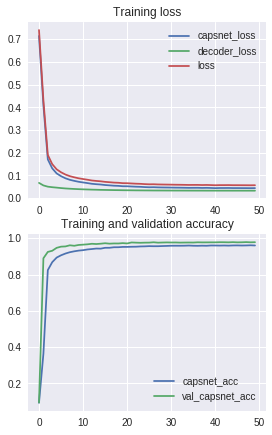

In [0]:
plot_log(args.save_dir + '/log.csv', show=True)

In [0]:
import shutil
src = "/content/result"
dst = "/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/result"
shutil.copy(src, dst)

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## CNN VGG

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.models import load_model
from keras.models import Model

Using TensorFlow backend.


In [0]:

# model = Sequential()

# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu', input_shape = (28,28,1)))
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))


# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))


# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation = "softmax"))

In [0]:
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [3]:
model_path = "/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/VGG16.h5"
model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


112
['/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 083654 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 083655 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 083656 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 083657 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 083658 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 083659 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 083660 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 100828 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 100829 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 100830 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/Cheque 100831 (1)/', '/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segment

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(936, 28, 28, 1)
(936, 28, 28, 1) ['Cheque 083654 (1)', 'Cheque 083655 (1)', 'Cheque 083656 (1)', 'Cheque 083657 (1)', 'Cheque 083658 (1)', 'Cheque 083659 (1)', 'Cheque 083660 (1)', 'Cheque 100828 (1)', 'Cheque 100829 (1)', 'Cheque 100830 (1)', 'Cheque 100831 (1)', 'Cheque 100832 (1)', 'Cheque 100833 (1)', 'Cheque 100834 (1)', 'Cheque 100835 (1)', 'Cheque 120611 (1)', 'Cheque 120612 (1)', 'Cheque 120613 (1)', 'Cheque 120614 (1)', 'Cheque 120615 (1)', 'Cheque 120616 (1)', 'Cheque 120617 (1)', 'Cheque 120618 (1)', 'Cheque 120619 (1)', 'Cheque 120620 (1)', 'Cheque 309061 (1)', 'Cheque 309062 (1)', 'Cheque 309063 (1)', 'Cheque 309066 (1)', 'Cheque 309067 (1)', 'Cheque 309068 (1)', 'Cheque 309069 (1)', 'Cheque 309070 (1)', 'Cheque 309071 (1)', 'Cheque 309072 (1)', 'Cheque 309073 (1)', 'Cheque 309074 (1)', 'Cheque 309075 (1)', 'Cheque 309076 (1)', 'Cheque 309077 (1)', 'Cheque 309078 (1)', 'Cheque 309079 (1)', 'Cheque 309080 (1)', 'Cheque 309082 (1)', 'Cheque 309083 (1)', 'Cheque 309084 (1)',

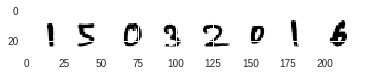

(8,)
['Cheque 083654 (1)', '1', '5', '0', '1', '2', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 7 0 2 0 0 1 0]

------------------------------End: test------------------------------


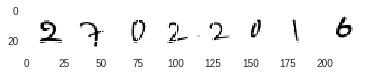

(8,)
['Cheque 083655 (1)', '2', '7', '0', '2', '0', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 1 0 0 2 0 1 0]

------------------------------End: test------------------------------


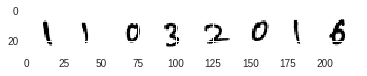

(8,)
['Cheque 083656 (1)', '1', '1', '0', '0', '2', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 0 0 1 2 0 1 0]

------------------------------End: test------------------------------


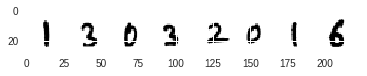

(8,)
['Cheque 083657 (1)', '1', '0', '0', '1', '2', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[0 0 1 0 0 1 2 0]

------------------------------End: test------------------------------


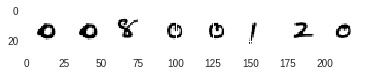

(8,)
['Cheque 083658 (1)', '0', '0', '1', '0', '0', '1', '2', '0']
------------------------------Begin: Prediction------------------------------
[0 1 1 1 1 1 1 0]

------------------------------End: test------------------------------


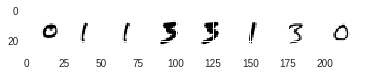

(8,)
['Cheque 083659 (1)', '0', '1', '1', '1', '1', '1', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 1 0 1 1 1 1 0]

------------------------------End: test------------------------------


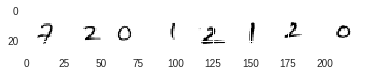

(8,)
['Cheque 083660 (1)', '1', '1', '0', '1', '1', '1', '1', '0']
------------------------------Begin: Prediction------------------------------
[8 1 0 1 1 2 8 0]

------------------------------End: test------------------------------


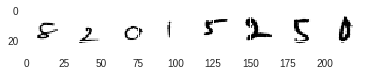

(8,)
['Cheque 100828 (1)', '8', '1', '0', '1', '1', '2', '8', '0']
------------------------------Begin: Prediction------------------------------
[1 2 0 1 1 0 1 0]

------------------------------End: test------------------------------


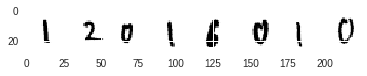

(8,)
['Cheque 100829 (1)', '1', '2', '0', '1', '1', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 2 0 1 0 0 8 0]

------------------------------End: test------------------------------


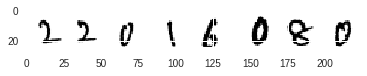

(8,)
['Cheque 100830 (1)', '2', '2', '0', '1', '0', '0', '8', '0']
------------------------------Begin: Prediction------------------------------
[2 2 0 1 0 1 8 0]

------------------------------End: test------------------------------


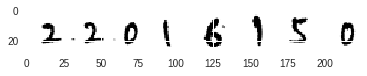

(8,)
['Cheque 100831 (1)', '2', '2', '0', '1', '0', '1', '8', '0']
------------------------------Begin: Prediction------------------------------
[0 2 0 1 4 1 0 0]

------------------------------End: test------------------------------


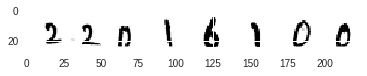

(8,)
['Cheque 100832 (1)', '0', '2', '0', '1', '4', '1', '0', '0']
------------------------------Begin: Prediction------------------------------
[4 2 0 1 8 1 0 0]

------------------------------End: test------------------------------


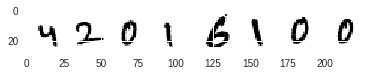

(8,)
['Cheque 100833 (1)', '4', '2', '0', '1', '8', '1', '0', '0']
------------------------------Begin: Prediction------------------------------
[0 2 0 1 0 1 8 0]

------------------------------End: test------------------------------


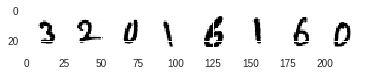

(8,)
['Cheque 100834 (1)', '0', '2', '0', '1', '0', '1', '8', '0']
------------------------------Begin: Prediction------------------------------
[2 2 0 1 0 1 8 0]

------------------------------End: test------------------------------


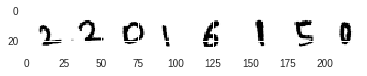

(8,)
['Cheque 100835 (1)', '2', '2', '0', '1', '0', '1', '8', '0']
------------------------------Begin: Prediction------------------------------
[2 0 0 1 4 1 2 0]

------------------------------End: test------------------------------


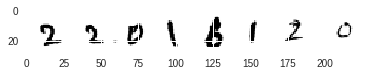

(8,)
['Cheque 120611 (1)', '2', '0', '0', '1', '4', '1', '2', '0']
------------------------------Begin: Prediction------------------------------
[0 1 0 0 7 0 0 0]

------------------------------End: test------------------------------


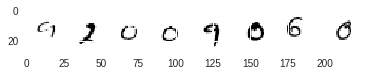

(8,)
['Cheque 120612 (1)', '0', '1', '0', '0', '7', '0', '0', '0']
------------------------------Begin: Prediction------------------------------
[0 0 0 0 9 0 1 1]

------------------------------End: test------------------------------


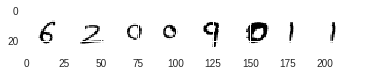

(8,)
['Cheque 120613 (1)', '0', '0', '0', '0', '9', '0', '1', '1']
------------------------------Begin: Prediction------------------------------
[1 0 0 0 0 0 5 5]

------------------------------End: test------------------------------


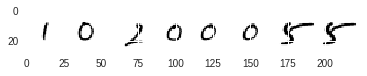

(8,)
['Cheque 120614 (1)', '1', '0', '0', '0', '0', '0', '5', '5']
------------------------------Begin: Prediction------------------------------
[2 0 0 1 1 2 2 2]

------------------------------End: test------------------------------


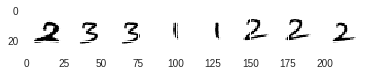

(8,)
['Cheque 120615 (1)', '2', '0', '0', '1', '1', '2', '2', '2']
------------------------------Begin: Prediction------------------------------
[2 0 0 0 0 0 0 1]

------------------------------End: test------------------------------


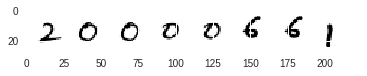

(8,)
['Cheque 120616 (1)', '2', '0', '0', '0', '0', '0', '0', '1']
------------------------------Begin: Prediction------------------------------
[1 1 2 2 0 1 2 1]

------------------------------End: test------------------------------


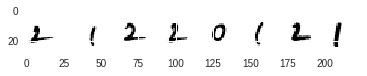

(8,)
['Cheque 120617 (1)', '1', '1', '2', '2', '0', '1', '2', '1']
------------------------------Begin: Prediction------------------------------
[1 1 2 2 0 1 1 2]

------------------------------End: test------------------------------


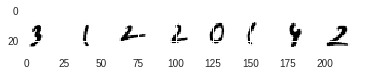

(8,)
['Cheque 120618 (1)', '1', '1', '2', '2', '0', '1', '1', '2']
------------------------------Begin: Prediction------------------------------
[4 0 0 1 0 1 1 2]

------------------------------End: test------------------------------


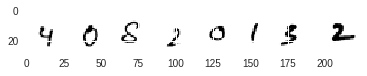

(8,)
['Cheque 120619 (1)', '4', '0', '0', '1', '0', '1', '1', '2']
------------------------------Begin: Prediction------------------------------
[2 0 9 1 0 1 1 1]

------------------------------End: test------------------------------


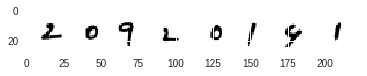

(8,)
['Cheque 120620 (1)', '2', '0', '9', '1', '0', '1', '1', '1']
------------------------------Begin: Prediction------------------------------
[1 1 1 1 1 1 1 1]

------------------------------End: test------------------------------


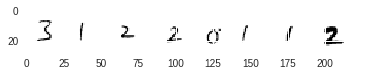

(8,)
['Cheque 309061 (1)', '1', '1', '1', '1', '1', '1', '1', '1']
------------------------------Begin: Prediction------------------------------
[1 1 1 1 0 1 1 1]

------------------------------End: test------------------------------


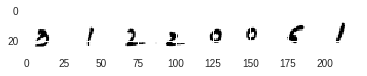

(8,)
['Cheque 309062 (1)', '1', '1', '1', '1', '0', '1', '1', '1']
------------------------------Begin: Prediction------------------------------
[1 0 1 1 0 1 5 2]

------------------------------End: test------------------------------


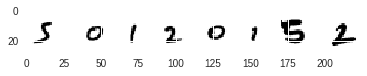

(8,)
['Cheque 309063 (1)', '1', '0', '1', '1', '0', '1', '5', '2']
------------------------------Begin: Prediction------------------------------
[8 0 1 0 0 1 8 1]

------------------------------End: test------------------------------


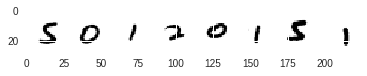

(8,)
['Cheque 309066 (1)', '8', '0', '1', '0', '0', '1', '8', '1']
------------------------------Begin: Prediction------------------------------
[9 1 1 1 1 1 4 2]

------------------------------End: test------------------------------


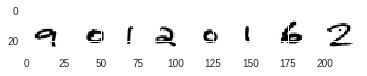

(8,)
['Cheque 309067 (1)', '9', '1', '1', '1', '1', '1', '4', '2']
------------------------------Begin: Prediction------------------------------
[4 0 1 0 1 1 1 4]

------------------------------End: test------------------------------


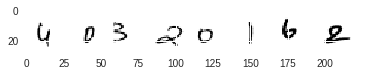

(8,)
['Cheque 309068 (1)', '4', '0', '1', '0', '1', '1', '1', '4']
------------------------------Begin: Prediction------------------------------
[8 0 1 0 0 1 4 1]

------------------------------End: test------------------------------


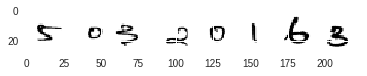

(8,)
['Cheque 309069 (1)', '8', '0', '1', '0', '0', '1', '4', '1']
------------------------------Begin: Prediction------------------------------
[0 0 4 0 0 1 4 1]

------------------------------End: test------------------------------


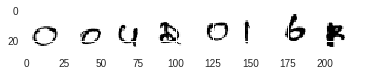

(8,)
['Cheque 309070 (1)', '0', '0', '4', '0', '0', '1', '4', '1']
------------------------------Begin: Prediction------------------------------
[1 0 5 0 0 1 1 1]

------------------------------End: test------------------------------


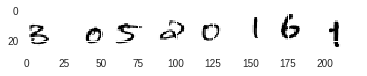

(8,)
['Cheque 309071 (1)', '1', '0', '5', '0', '0', '1', '1', '1']
------------------------------Begin: Prediction------------------------------
[7 0 1 0 0 1 1 2]

------------------------------End: test------------------------------


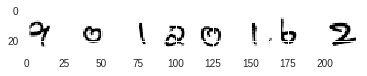

(8,)
['Cheque 309072 (1)', '7', '0', '1', '0', '0', '1', '1', '2']
------------------------------Begin: Prediction------------------------------
[5 0 1 4 4 0 1 1]

------------------------------End: test------------------------------


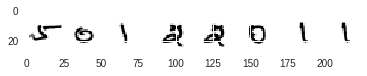

(8,)
['Cheque 309073 (1)', '5', '0', '1', '4', '4', '0', '1', '1']
------------------------------Begin: Prediction------------------------------
[6 6 1 0 2 1 0 0]

------------------------------End: test------------------------------


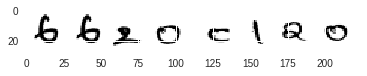

(8,)
['Cheque 309074 (1)', '6', '6', '1', '0', '2', '1', '0', '0']
------------------------------Begin: Prediction------------------------------
[1 0 0 8 0 1 0 0]

------------------------------End: test------------------------------


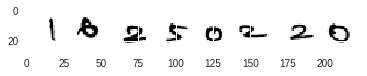

(8,)
['Cheque 309075 (1)', '1', '0', '0', '8', '0', '1', '0', '0']
------------------------------Begin: Prediction------------------------------
[1 4 1 1 1 1 1 0]

------------------------------End: test------------------------------


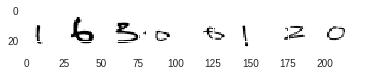

(8,)
['Cheque 309076 (1)', '1', '4', '1', '1', '1', '1', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 1 1 0 0 1 1 0]

------------------------------End: test------------------------------


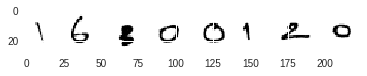

(8,)
['Cheque 309077 (1)', '1', '1', '1', '0', '0', '1', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 4 2 1 0 1 2 0]

------------------------------End: test------------------------------


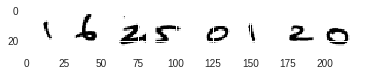

(8,)
['Cheque 309078 (1)', '1', '4', '2', '1', '0', '1', '2', '0']
------------------------------Begin: Prediction------------------------------
[1 4 1 1 9 9 0 0]

------------------------------End: test------------------------------


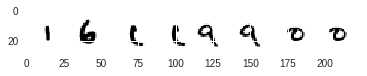

(8,)
['Cheque 309079 (1)', '1', '4', '1', '1', '9', '9', '0', '0']
------------------------------Begin: Prediction------------------------------
[1 1 1 0 0 1 4 1]

------------------------------End: test------------------------------


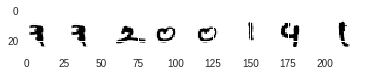

(8,)
['Cheque 309080 (1)', '1', '1', '1', '0', '0', '1', '4', '1']
------------------------------Begin: Prediction------------------------------
[4 4 0 0 1 1 1 1]

------------------------------End: test------------------------------


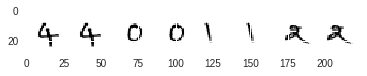

(8,)
['Cheque 309082 (1)', '4', '4', '0', '0', '1', '1', '1', '1']
------------------------------Begin: Prediction------------------------------
[0 0 1 1 5 5 1 0]

------------------------------End: test------------------------------


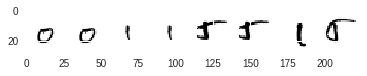

(8,)
['Cheque 309083 (1)', '0', '0', '1', '1', '5', '5', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 1 1 0 1 8 1 0]

------------------------------End: test------------------------------


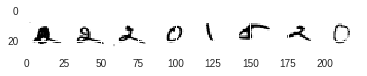

(8,)
['Cheque 309084 (1)', '1', '1', '1', '0', '1', '8', '1', '0']
------------------------------Begin: Prediction------------------------------
[0 1 1 1 1 1 0 0]

------------------------------End: test------------------------------


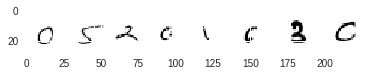

(8,)
['Cheque 309086 (1)', '0', '1', '1', '1', '1', '1', '0', '0']
------------------------------Begin: Prediction------------------------------
[0 4 1 1 1 8 7 1]

------------------------------End: test------------------------------


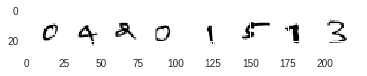

(8,)
['Cheque 309089 (1)', '0', '4', '1', '1', '1', '8', '7', '1']
------------------------------Begin: Prediction------------------------------
[0 1 1 0 1 1 1 0]

------------------------------End: test------------------------------


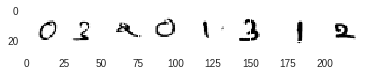

(8,)
['Cheque 309090 (1)', '0', '1', '1', '0', '1', '1', '1', '0']
------------------------------Begin: Prediction------------------------------
[0 0 0 0 1 8 0 0]

------------------------------End: test------------------------------


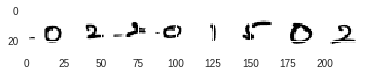

(8,)
['Cheque 309091 (1)', '0', '0', '0', '0', '1', '8', '0', '0']
------------------------------Begin: Prediction------------------------------
[0 2 4 0 0 2 1 1]

------------------------------End: test------------------------------


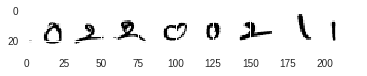

(8,)
['Cheque 309092 (1)', '0', '2', '4', '0', '0', '2', '1', '1']
------------------------------Begin: Prediction------------------------------
[1 2 1 0 1 5 0 4]

------------------------------End: test------------------------------


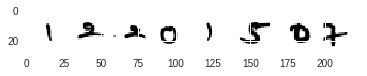

(8,)
['Cheque 309093 (1)', '1', '2', '1', '0', '1', '5', '0', '4']
------------------------------Begin: Prediction------------------------------
[0 2 2 4 1 4 1 0]

------------------------------End: test------------------------------


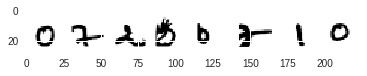

(8,)
['Cheque 309094 (1)', '0', '2', '2', '4', '1', '4', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 1 2 0 1 5 0 0]

------------------------------End: test------------------------------


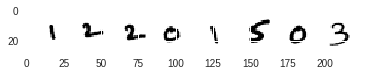

(8,)
['Cheque 309095 (1)', '1', '1', '2', '0', '1', '5', '0', '0']
------------------------------Begin: Prediction------------------------------
[0 1 2 0 1 4 1 1]

------------------------------End: test------------------------------


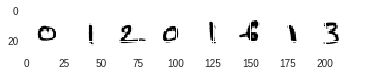

(8,)
['Cheque 309096 (1)', '0', '1', '2', '0', '1', '4', '1', '1']
------------------------------Begin: Prediction------------------------------
[0 1 2 0 1 4 1 1]

------------------------------End: test------------------------------


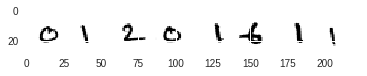

(8,)
['Cheque 309097 (1)', '0', '1', '2', '0', '1', '4', '1', '1']
------------------------------Begin: Prediction------------------------------
[1 1 2 0 1 5 0 0]

------------------------------End: test------------------------------


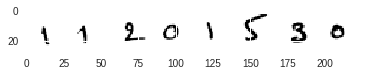

(8,)
['Cheque 309098 (1)', '1', '1', '2', '0', '1', '5', '0', '0']
------------------------------Begin: Prediction------------------------------
[1 2 1 0 1 8 0 9]

------------------------------End: test------------------------------


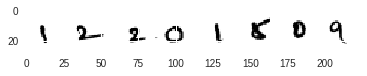

(8,)
['Cheque 309099 (1)', '1', '2', '1', '0', '1', '8', '0', '9']
------------------------------Begin: Prediction------------------------------
[0 7 0 0 1 8 1 0]

------------------------------End: test------------------------------


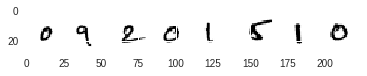

(8,)
['Cheque 309100 (1)', '0', '7', '0', '0', '1', '8', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 0 2 0 1 8 0 1]

------------------------------End: test------------------------------


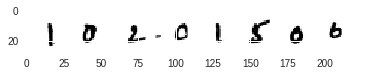

(8,)
['Cheque 309101 (1)', '1', '0', '2', '0', '1', '8', '0', '1']
------------------------------Begin: Prediction------------------------------
[0 1 2 0 1 8 2 1]

------------------------------End: test------------------------------


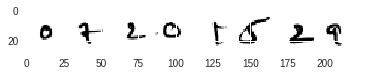

(8,)
['Cheque 309102 (1)', '0', '1', '2', '0', '1', '8', '2', '1']
------------------------------Begin: Prediction------------------------------
[1 1 2 0 1 8 1 0]

------------------------------End: test------------------------------


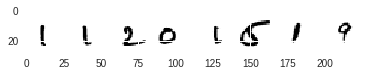

(8,)
['Cheque 309103 (1)', '1', '1', '2', '0', '1', '8', '1', '0']
------------------------------Begin: Prediction------------------------------
[1 1 1 1 1 1 0 0]

------------------------------End: test------------------------------


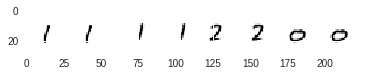

(8,)
['Cheque 309104 (1)', '1', '1', '1', '1', '1', '1', '0', '0']
------------------------------Begin: Prediction------------------------------
[1 1 1 0 7 0 7 1]

------------------------------End: test------------------------------


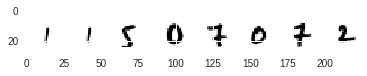

(8,)
['Cheque 309105 (1)', '1', '1', '1', '0', '7', '0', '7', '1']
------------------------------Begin: Prediction------------------------------
[0 1 8 0 4 1 1 1]

------------------------------End: test------------------------------


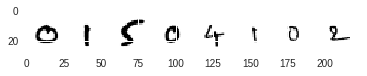

(8,)
['Cheque 309106 (1)', '0', '1', '8', '0', '4', '1', '1', '1']
------------------------------Begin: Prediction------------------------------
[0 1 1 2 0 0 1 1]

------------------------------End: test------------------------------


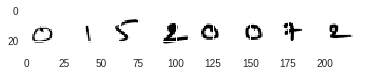

(8,)
['Cheque 309107 (1)', '0', '1', '1', '2', '0', '0', '1', '1']
------------------------------Begin: Prediction------------------------------
[0 1 8 2 0 0 7 1]

------------------------------End: test------------------------------


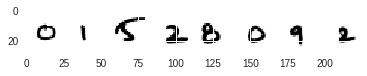

(8,)
['Cheque 309108 (1)', '0', '1', '8', '2', '0', '0', '7', '1']
------------------------------Begin: Prediction------------------------------
[0 1 8 1 8 0 1 2]

------------------------------End: test------------------------------


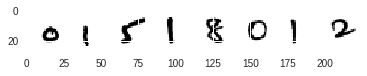

(8,)
['Cheque 309109 (1)', '0', '1', '8', '1', '8', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[0 1 8 1 9 0 1 2]

------------------------------End: test------------------------------


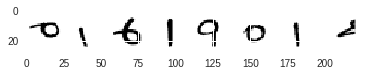

(8,)
['Cheque 309110 (1)', '0', '1', '8', '1', '9', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[4 1 8 1 9 0 1 2]

------------------------------End: test------------------------------


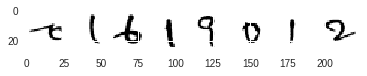

(8,)
['Cheque 309111 (1)', '4', '1', '8', '1', '9', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[0 1 4 1 9 0 1 4]

------------------------------End: test------------------------------


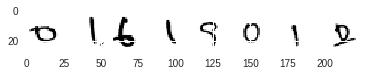

(8,)
['Cheque 309112 (1)', '0', '1', '4', '1', '9', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[0 1 4 2 0 0 2 0]

------------------------------End: test------------------------------


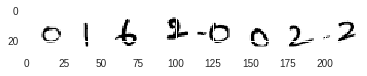

(8,)
['Cheque 309113 (1)', '0', '1', '4', '2', '0', '0', '2', '0']
------------------------------Begin: Prediction------------------------------
[0 1 4 2 1 0 1 0]

------------------------------End: test------------------------------


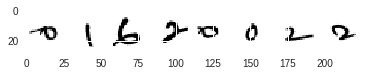

(8,)
['Cheque 309114 (1)', '0', '1', '4', '2', '1', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[0 1 1 2 2 0 1 2]

------------------------------End: test------------------------------


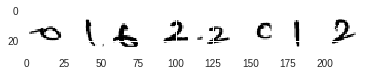

(8,)
['Cheque 309115 (1)', '0', '1', '1', '2', '2', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[0 1 8 2 1 0 2 2]

------------------------------End: test------------------------------


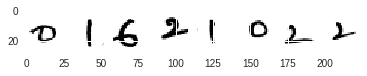

(8,)
['Cheque 309116 (1)', '0', '1', '8', '2', '1', '0', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 4 2 1 0 2 0]

------------------------------End: test------------------------------


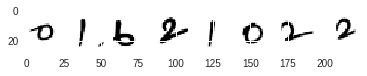

(8,)
['Cheque 309117 (1)', '0', '1', '4', '2', '1', '0', '2', '0']
------------------------------Begin: Prediction------------------------------
[0 1 1 2 0 0 1 2]

------------------------------End: test------------------------------


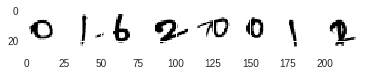

(8,)
['Cheque 309118 (1)', '0', '1', '1', '2', '0', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[0 1 4 4 1 0 1 2]

------------------------------End: test------------------------------


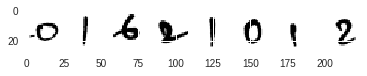

(8,)
['Cheque 309119 (1)', '0', '1', '4', '4', '1', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[0 1 5 2 1 0 1 0]

------------------------------End: test------------------------------


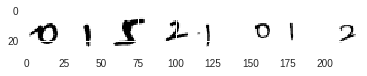

(8,)
['Cheque 309121 (1)', '0', '1', '5', '2', '1', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[0 1 4 2 0 0 1 1]

------------------------------End: test------------------------------


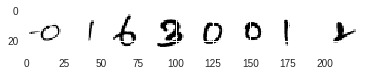

(8,)
['Cheque 309122 (1)', '0', '1', '4', '2', '0', '0', '1', '1']
------------------------------Begin: Prediction------------------------------
[0 1 4 2 0 1 2 0]

------------------------------End: test------------------------------


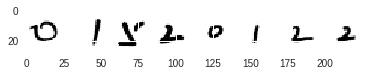

(8,)
['Cheque 309123 (1)', '0', '1', '4', '2', '0', '1', '2', '0']
------------------------------Begin: Prediction------------------------------
[1 1 1 1 9 0 1 2]

------------------------------End: test------------------------------


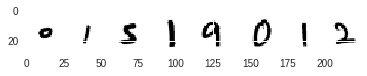

(8,)
['Cheque 309124 (1)', '1', '1', '1', '1', '9', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[0 1 4 1 0 0 1 1]

------------------------------End: test------------------------------


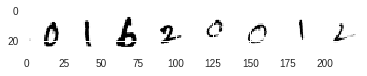

(8,)
['Cheque 309125 (1)', '0', '1', '4', '1', '0', '0', '1', '1']
------------------------------Begin: Prediction------------------------------
[0 1 5 1 2 1 2 2]

------------------------------End: test------------------------------


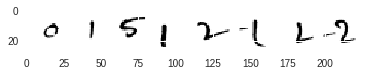

(8,)
['Cheque 309126 (1)', '0', '1', '5', '1', '2', '1', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 5 1 5 1 2 4]

------------------------------End: test------------------------------


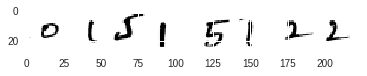

(8,)
['Cheque 309127 (1)', '0', '1', '5', '1', '5', '1', '2', '4']
------------------------------Begin: Prediction------------------------------
[0 1 8 1 8 1 2 2]

------------------------------End: test------------------------------


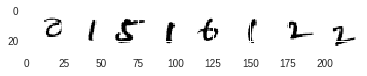

(8,)
['Cheque 309128 (1)', '0', '1', '8', '1', '8', '1', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 4 1 7 1 2 0]

------------------------------End: test------------------------------


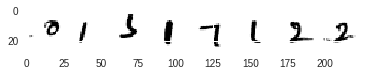

(8,)
['Cheque 309129 (1)', '0', '1', '4', '1', '7', '1', '2', '0']
------------------------------Begin: Prediction------------------------------
[0 1 5 1 8 1 2 2]

------------------------------End: test------------------------------


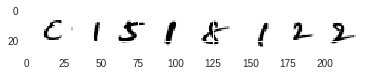

(8,)
['Cheque 309130 (1)', '0', '1', '5', '1', '8', '1', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 5 1 9 1 2 2]

------------------------------End: test------------------------------


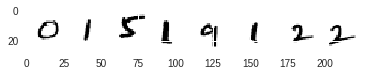

(8,)
['Cheque 309131 (1)', '0', '1', '5', '1', '9', '1', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 1 1 9 1 2 2]

------------------------------End: test------------------------------


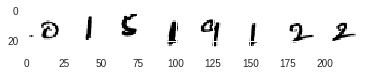

(8,)
['Cheque 309133 (1)', '0', '1', '1', '1', '9', '1', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 5 2 0 1 2 2]

------------------------------End: test------------------------------


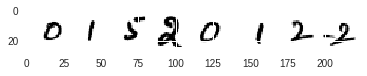

(8,)
['Cheque 309134 (1)', '0', '1', '5', '2', '0', '1', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 8 2 0 1 1 4]

------------------------------End: test------------------------------


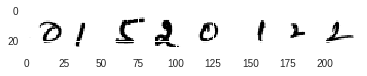

(8,)
['Cheque 309135 (1)', '0', '1', '8', '2', '0', '1', '1', '4']
------------------------------Begin: Prediction------------------------------
[1 4 5 1 2 1 2 4]

------------------------------End: test------------------------------


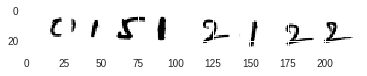

(8,)
['Cheque 309136 (1)', '1', '4', '5', '1', '2', '1', '2', '4']
------------------------------Begin: Prediction------------------------------
[0 1 8 2 0 1 2 2]

------------------------------End: test------------------------------


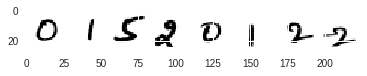

(8,)
['Cheque 309137 (1)', '0', '1', '8', '2', '0', '1', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 4 4 0 1 2 2]

------------------------------End: test------------------------------


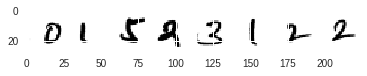

(8,)
['Cheque 309138 (1)', '0', '1', '4', '4', '0', '1', '2', '2']
------------------------------Begin: Prediction------------------------------
[0 1 4 2 5 0 1 2]

------------------------------End: test------------------------------


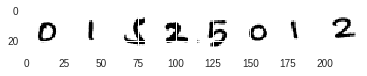

(8,)
['Cheque 309139 (1)', '0', '1', '4', '2', '5', '0', '1', '2']
------------------------------Begin: Prediction------------------------------
[0 1 0 2 2 5 5 0]

------------------------------End: test------------------------------


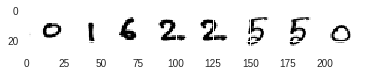

(8,)
['Cheque 309141 (1)', '0', '1', '0', '2', '2', '5', '5', '0']
------------------------------Begin: Prediction------------------------------
[0 1 1 2 0 0 1 0]

------------------------------End: test------------------------------


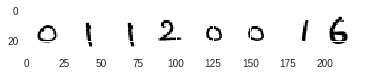

(8,)
['Cheque 309142 (1)', '0', '1', '1', '2', '0', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 0]

------------------------------End: test------------------------------


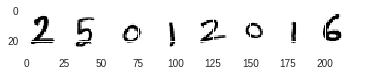

(8,)
['Cheque 309144 (1)', '2', '5', '0', '1', '2', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 0]

------------------------------End: test------------------------------


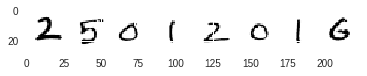

(8,)
['Cheque 309145 (1)', '2', '5', '0', '1', '2', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 4]

------------------------------End: test------------------------------


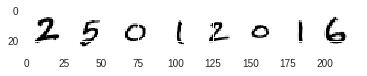

(8,)
['Cheque 309147 (1)', '2', '5', '0', '1', '2', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 4]

------------------------------End: test------------------------------


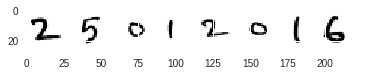

(8,)
['Cheque 309148 (1)', '2', '5', '0', '1', '2', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 0 0 1 4]

------------------------------End: test------------------------------


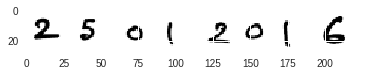

(8,)
['Cheque 309149 (1)', '2', '5', '0', '1', '0', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 6]

------------------------------End: test------------------------------


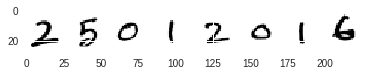

(8,)
['Cheque 309150 (1)', '2', '5', '0', '1', '2', '0', '1', '6']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 4]

------------------------------End: test------------------------------


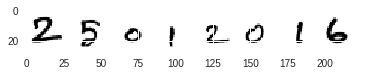

(8,)
['Cheque 309151 (1)', '2', '5', '0', '1', '2', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 1]

------------------------------End: test------------------------------


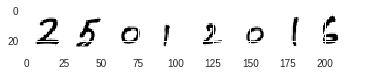

(8,)
['Cheque 309153 (1)', '2', '5', '0', '1', '2', '0', '1', '1']
------------------------------Begin: Prediction------------------------------
[2 5 0 1 2 0 1 4]

------------------------------End: test------------------------------


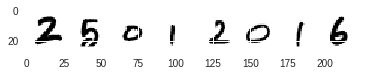

(8,)
['Cheque 309155 (1)', '2', '5', '0', '1', '2', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[1 0 0 1 2 0 1 1]

------------------------------End: test------------------------------


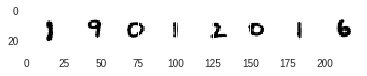

(8,)
['Cheque 309156 (1)', '1', '0', '0', '1', '2', '0', '1', '1']
------------------------------Begin: Prediction------------------------------
[2 0 0 1 1 0 1 4]

------------------------------End: test------------------------------


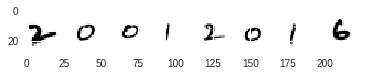

(8,)
['Cheque 309157 (1)', '2', '0', '0', '1', '1', '0', '1', '4']
------------------------------Begin: Prediction------------------------------
[2 1 0 1 1 1 1 0]

------------------------------End: test------------------------------


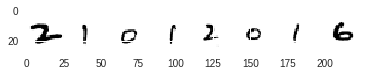

(8,)
['Cheque 309158 (1)', '2', '1', '0', '1', '1', '1', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 1 0 1 1 1 1 4]

------------------------------End: test------------------------------


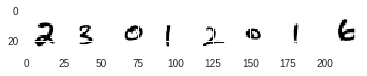

(8,)
['Cheque 309159 (1)', '2', '1', '0', '1', '1', '1', '1', '4']
------------------------------Begin: Prediction------------------------------
[1 0 1 1 1 0 1 0]

------------------------------End: test------------------------------


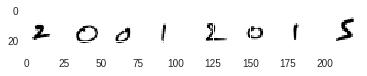

(8,)
['Cheque 309160 (1)', '1', '0', '1', '1', '1', '0', '1', '0']
------------------------------Begin: Prediction------------------------------
[2 7 1 2 1 0 1 5]

------------------------------End: test------------------------------


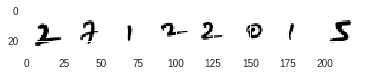

(8,)


IndexError: ignored

In [8]:
from keras.preprocessing import image
import glob
import os
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
def test_my_data(model, data):
    x_test = data
    y_pred = model.predict(x_test, batch_size=8)
    print('-'*30 + 'Begin: Prediction' + '-'*30)
#     print('-'*30 + y_pred + '-'*30)
#     print(y_pred)
    output = np.argmax(y_pred, axis=1)
    print (output)

#     img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    img = combine_images(x_test, height = 1)
    image = img * 255
    image = image.astype(np.uint8)
#     cv2.imwrite("/detected-boxes.jpg", image)
    #Image.fromarray(image).save(args.save_dir + "/real_and_recon.png")
    print()
#     print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
#     plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
#     plt.imshow(plt.imread("/detected-boxes.jpg"))
    plt.imshow(image)
    plt.show()
    return output
    
def load_prediction_data():
    # the data, shuffled and split between train and test sets
    pred_data = None
#     dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/"
    dir_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/date_segmented4/"
    dirs = glob.glob(dir_path + "*/")
#     print (dirs)
    print (len(dirs))
    dirs.sort()
    cheque_names = []
    print (dirs)
    for direct in dirs:
      onlyfiles = glob.glob(direct + "*.tif")
      onlyfiles.sort()
#       print(onlyfiles)
      i=0
      for filepath in onlyfiles:
        __, filename = os.path.split(filepath)
        i+=1
        img = image.load_img(filepath, target_size=(28, 28), grayscale = True)
  #       print(type(img))
        
        x = image.img_to_array(img)
  #       print(type(x))
        x = x.astype('float32') / 255.
      #   plt.imshow(x/255.)
        if pred_data is None:
          pred_data = np.array([x])
        else:
          pred_data = np.concatenate((pred_data, [x]))
      #     img_path = "/content/gdrive/My Drive/Nisarg Colab/Datasets/mnist_prediction_data/position_1.tif"
      cheque_names.append(direct.split('/')[-2])
    print(pred_data.shape)
    return pred_data, cheque_names

x_test, cheque_names = load_prediction_data()
print(x_test.shape, cheque_names)
for i in range(0, x_test.shape[0], 8):
    output = test_my_data(model=model, data=x_test[i:i+8,])
    print (output.shape)
    list_output = output.tolist()
#     str_output = ""
#     for j in range(0, len(list_output)):
#         str_output += str(list_output[j])
#     print (str_output)
#     myData = [cheque_names[i//8],str_output]

    list_out = []
    myData = [cheque_names[i//8]]
    for j in range(0, len(list_output)):
        myData.append(str(list_output[j]))
        
    print (myData)
    myFile = open('/content/gdrive/My Drive/Nisarg Colab/Colab Notebooks/Capsnet_Num/date_vgg_separate_2.csv', 'a')
    with myFile:  
      writer = csv.writer(myFile) 
      writer.writerow(myData)